# CNN-based Regressor model
The goal is to train and evaluate a model that, given a droplets' segmentation mask, predicts the following statistics:
- left contact angle
- right contact angle
- volume
- ellipse xc (x coordinate of the center of the ellipse)
- ellipse yc (y coordinate of the center of the ellipse)
- ellipse a (half the length of the major axis of the ellipse)
- ellipse b (half the length of the minor axis of the ellipse)
- ellipse theta (rotation angle of the ellipse (in radians), counter-clockwise from the x-axis to the ellipse’s major axis)
- bbox x (x coordinate of the left bottom vertex of the bounding box)
- bbox y (y coordinate of the left bottom vertex of the bounding box)
- bbox w (width of the bounding box)
- bbox h (height of the bounding box)

## Defining the dataset

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torchvision.transforms as transforms

MASK_DIR = "../3. Segmentation and Detection Models/droplet_masks"
REGRESSION_INFO_PATH = "../5. Robust Estimation and Evaluation Methods/analysis/droplet_analysis.csv"

transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((180, 240)), # the original images from the video are 720x540, and 180x240 preserves the aspect ratio (4:3)
    transforms.ToTensor()
])

class DropletRegressionDataset(Dataset):
    def __init__(self, mask_dir, df, scaled_labels, transform=None):
        self.mask_dir = mask_dir
        self.df = df.reset_index(drop=True)  # ensure indexing matches scaled labels
        self.scaled_labels = scaled_labels
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        frame_code = int(self.df.iloc[idx]["Frame"])
        frame_code_str = f"{frame_code:03d}"
        mask_path = os.path.join(self.mask_dir, f"frame_{frame_code_str}_mask.png")

        mask = Image.open(mask_path).convert("L")
        if self.transform:
            mask = self.transform(mask)
        else:
            mask = torch.tensor(np.array(mask), dtype=torch.float32).unsqueeze(0) / 255.0

        label = self.scaled_labels[idx]  # already scaled
        return mask, torch.tensor(label, dtype=torch.float32)


In [4]:
from sklearn.preprocessing import StandardScaler

df = pd.read_csv(REGRESSION_INFO_PATH)
df.drop(df[df.Valid == 'False'].index, inplace=True) # drop not valid rows
df = df.drop(columns=["Volume_Loss", "Valid"]).dropna() # remove unneeded columns
labels_np = df.iloc[:, 1:].values  # exclude Frame column

# Normalize labels
scaler = StandardScaler()
scaled_labels = scaler.fit_transform(labels_np)

In [5]:
dataset = DropletRegressionDataset(MASK_DIR, df, scaled_labels, transform)

# Create DataLoader for testing
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Fetch a single batch
masks, targets = next(iter(dataloader))

# Display some info
print("Masks shape:", masks.shape)       # Expect [B, 1, H, W]
print("Targets shape:", targets.shape)   # Expect [B, 12]
print("First sample targets:\n", targets[0])

Masks shape: torch.Size([4, 1, 180, 240])
Targets shape: torch.Size([4, 12])
First sample targets:
 tensor([-0.3922, -0.4431, -0.6697, -0.5119,  1.0932, -0.3351, -0.4979, -0.0034,
        -0.2107,  0.9746, -0.3572, -0.9746])


Split the dataset in (80%) train and (20%) test

In [6]:
from torch.utils.data import random_split, DataLoader

# Define dataset lengths
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Defining the model

In [7]:
import torch.nn as nn

class DropletCNNRegressor(nn.Module):
    def __init__(self):
        super(DropletCNNRegressor, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # grayscale input
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(128 * 45 * 60, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 12)
        )

    def forward(self, x):
        return self.net(x)

## Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = DropletCNNRegressor().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

num_epochs = 40
patience = 3

# Early stopping and tracking
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []
val_r2_scores = []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", ncols=100)

    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []
    val_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=True, ncols=100)

    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            val_bar.set_postfix(val_loss=loss.item())

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)

    # R^2 for this validation epoch
    all_preds_np = np.vstack(all_preds)
    all_labels_np = np.vstack(all_labels)
    val_r2 = r2_score(all_labels_np, all_preds_np)
    val_r2_scores.append(val_r2)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Val R²: {val_r2:.4f}")

    torch.save(model.state_dict(), f"cnn_regressor_last.pth")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping: Validation loss did not improve for ${patience} epochs.")
            break

end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal training time: {total_time:.2f} seconds")

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/40 [Val]: 100%|████████████████████████████| 63/63 [01:30<00:00,  1.44s/it, val_loss=0.0529]


Epoch [1/40] - Train Loss: 0.2138 - Val Loss: 0.0704 - Val R²: 0.7601


Epoch 2/40 [Train]:   0%|                                                   | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2/40 [Val]: 100%|████████████████████████████| 63/63 [00:06<00:00,  9.42it/s, val_loss=0.0536]


Epoch [2/40] - Train Loss: 0.0951 - Val Loss: 0.0609 - Val R²: 0.7868


Epoch 3/40 [Train]:   0%|                                                   | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3/40 [Val]: 100%|████████████████████████████| 63/63 [00:06<00:00,  9.30it/s, val_loss=0.0155]


Epoch [3/40] - Train Loss: 0.0749 - Val Loss: 0.0427 - Val R²: 0.8385


Epoch 4/40 [Train]:   0%|                                                   | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4/40 [Val]: 100%|████████████████████████████| 63/63 [00:06<00:00,  9.87it/s, val_loss=0.0234]


Epoch [4/40] - Train Loss: 0.0564 - Val Loss: 0.0247 - Val R²: 0.8825


Epoch 5/40 [Train]:   0%|                                                   | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5/40 [Val]: 100%|█████████████████████████████| 63/63 [00:05<00:00, 11.89it/s, val_loss=0.022]


Epoch [5/40] - Train Loss: 0.0433 - Val Loss: 0.0213 - Val R²: 0.8906


Epoch 6/40 [Train]:   0%|                                                   | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6/40 [Val]: 100%|████████████████████████████| 63/63 [00:05<00:00, 12.11it/s, val_loss=0.0153]


Epoch [6/40] - Train Loss: 0.0376 - Val Loss: 0.0190 - Val R²: 0.8951


Epoch 7/40 [Train]:   0%|                                                   | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7/40 [Val]: 100%|███████████████████████████| 63/63 [00:06<00:00, 10.30it/s, val_loss=0.00918]


Epoch [7/40] - Train Loss: 0.0344 - Val Loss: 0.0174 - Val R²: 0.8985


Epoch 8/40 [Train]:   0%|                                                   | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8/40 [Val]: 100%|████████████████████████████| 63/63 [00:06<00:00,  9.38it/s, val_loss=0.0239]


Epoch [8/40] - Train Loss: 0.0345 - Val Loss: 0.0232 - Val R²: 0.8868


Epoch 9/40 [Train]:   0%|                                                   | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9/40 [Val]: 100%|███████████████████████████| 63/63 [00:06<00:00,  9.43it/s, val_loss=0.00846]


Epoch [9/40] - Train Loss: 0.0323 - Val Loss: 0.0178 - Val R²: 0.8977


Epoch 10/40 [Train]:   0%|                                                  | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10/40 [Val]: 100%|███████████████████████████| 63/63 [00:06<00:00, 10.10it/s, val_loss=0.0096]


Epoch [10/40] - Train Loss: 0.0304 - Val Loss: 0.0166 - Val R²: 0.9001


Epoch 11/40 [Train]:   0%|                                                  | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 11/40 [Val]: 100%|██████████████████████████| 63/63 [00:05<00:00, 11.92it/s, val_loss=0.00882]


Epoch [11/40] - Train Loss: 0.0310 - Val Loss: 0.0172 - Val R²: 0.8991


Epoch 12/40 [Train]:   0%|                                                  | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 12/40 [Val]: 100%|███████████████████████████| 63/63 [00:05<00:00, 12.06it/s, val_loss=0.0159]


Epoch [12/40] - Train Loss: 0.0299 - Val Loss: 0.0176 - Val R²: 0.8983


Epoch 13/40 [Train]:   0%|                                                  | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 13/40 [Val]: 100%|███████████████████████████| 63/63 [00:08<00:00,  7.83it/s, val_loss=0.0122]


Epoch [13/40] - Train Loss: 0.0293 - Val Loss: 0.0171 - Val R²: 0.8995
Early stopping: Validation loss did not improve.

Total training time: 955.70 seconds


In [ ]:
MODEL_SAVE_PATH = "cnn_regressor_best.pth"
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

Model saved to /content/drive/MyDrive/Pi2/cnn_regressor_best.pth


## Evaluating the model

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).cpu().numpy()
        labels = labels.cpu().numpy()

        all_preds.append(outputs)
        all_targets.append(labels)

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

mae = mean_absolute_error(all_targets, all_preds)
mse = mean_squared_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)

print(f"\nFinal Evaluation:")
print(f"  MAE  = {mae:.4f}")
print(f"  MSE  = {mse:.4f}")
print(f"  R²   = {r2:.4f}")

print("\nSample Predictions (3 random examples):")
indices = random.sample(range(len(all_targets)), 3)
for i in indices:
    print(f"\nExample {i+1}:")
    print(f"  Ground truth : {np.round(all_targets[i], 2)}")
    print(f"  Prediction   : {np.round(all_preds[i], 2)}")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Final Evaluation:
  MAE  = 0.1107
  MSE  = 0.0950
  R²   = 0.8991

Sample Predictions (3 random examples):

Example 485:
  Ground truth : [-0.11 -0.05 -0.56 -0.57  0.7  -0.31 -0.54 -0.08 -0.27  0.73 -0.36 -0.73]
  Prediction   : [-0.12 -0.13 -0.45 -0.47  0.66 -0.22 -0.4  -0.05 -0.25  0.7  -0.25 -0.73]

Example 828:
  Ground truth : [-0.09 -0.19 -0.44 -0.61  0.66 -0.21 -0.4  -0.12 -0.32  0.65 -0.22 -0.65]
  Prediction   : [-0.14 -0.14 -0.45 -0.48  0.59 -0.2  -0.35 -0.08 -0.27  0.61 -0.22 -0.66]

Example 843:
  Ground truth : [-0.72 -0.5  -0.73 -0.46  1.29 -0.32 -0.54 -0.02 -0.21  1.06 -0.29 -1.06]
  Prediction   : [-0.36 -0.28 -0.7  -0.39  1.1  -0.31 -0.51  0.03 -0.2   0.92 -0.33 -0.97]


## Plotting

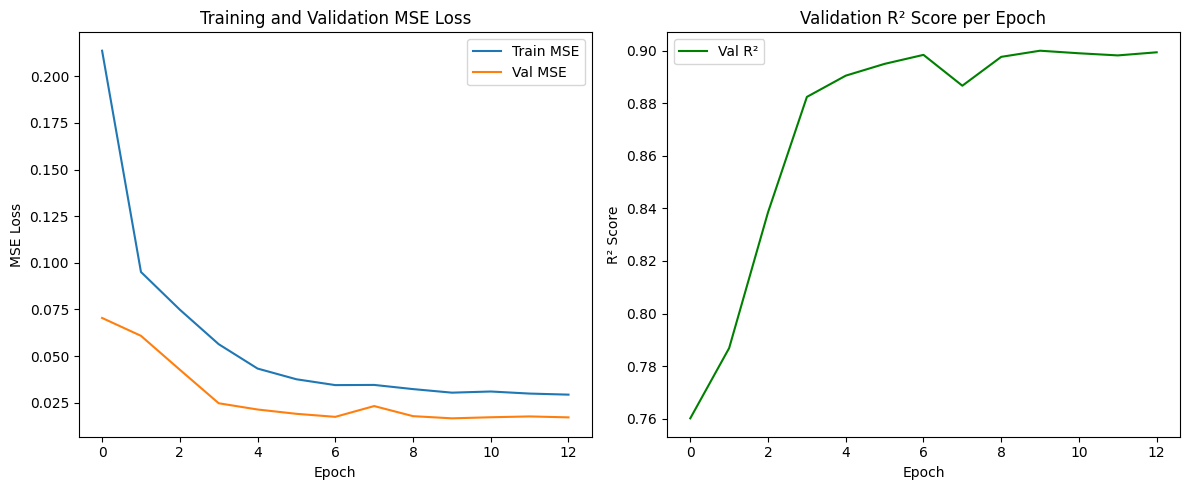

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train MSE')
plt.plot(val_losses, label='Val MSE')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation MSE Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_r2_scores, label='Val R²', color='green')
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("Validation R² Score per Epoch")
plt.legend()

plt.tight_layout()
plt.show()